<a href="https://colab.research.google.com/github/FatemehRajabi/gold-usd-prediction/blob/main/gold_price_lstm_achilles_reproduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install yfinance scikit-learn


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Get today's date
today = datetime.date.today()

# Load Gold ETF (GLD) data from Yahoo Finance
data = yf.download('GLD', start='2015-01-01', end=today)

# Flatten MultiIndex
data.columns = data.columns.get_level_values(0)
data.columns.name = None

# Keep only relevant columns
data = data[['Open', 'High', 'Low', 'Close', 'Volume']].dropna()

data.head()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2015-01-02,112.489998,114.800003,112.320000,114.080002,7109600
2015-01-05,114.779999,116.000000,114.730003,115.800003,8177400
2015-01-06,116.220001,117.500000,115.800003,117.120003,11238300
2015-01-07,116.470001,116.879997,116.169998,116.430000,6434200
2015-01-08,116.449997,116.870003,115.849998,115.940002,7033700


In [12]:
# Simple Moving Averages
data['SMA_10'] = data['Close'].rolling(window=10).mean()
data['SMA_30'] = data['Close'].rolling(window=30).mean()

# Relative Strength Index (RSI)
delta = data['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
data['RSI_14'] = 100 - (100 / (1 + rs))

# 14-day EMA of the Close price
data['EMA_14'] = data['Close'].ewm(span=14, adjust=False).mean()

# 30-day EMA of the Close price
data['EMA_30'] = data['Close'].ewm(span=30, adjust=False).mean()

# MACD (Moving Average Convergence Divergence)
ema_12 = data['Close'].ewm(span=12, adjust=False).mean()
ema_26 = data['Close'].ewm(span=26, adjust=False).mean()
data['MACD'] = ema_12 - ema_26

# Bollinger Bands (Volatility Indicator)
sma_20 = data['Close'].rolling(window=20).mean()
std_20 = data['Close'].rolling(window=20).std()

data['Bollinger_Upper'] = sma_20 + (2 * std_20)
data['Bollinger_Lower'] = sma_20 - (2 * std_20)

# Momentum
data['Momentum'] = data['Close'] - data['Close'].shift(10)

# Drop rows with NaNs from indicators
data.dropna(inplace=True)

data.head()

,Open,High,Low,Close,Volume,SMA_10,SMA_30,RSI_14,EMA_14,EMA_30,MACD,Bollinger_Upper,Bollinger_Lower,Momentum
Date,,,,,,,,,,,,,,
2015-06-19,115.339996,115.459999,114.949997,115.120003,4611600,113.700001,114.471333,57.106619,114.018477,114.107049,-0.049278,115.540071,112.029929,2.880005
2015-06-22,113.790001,113.940002,113.339996,113.639999,5763700,113.807001,114.460333,45.393261,113.968013,114.076916,-0.077071,115.220213,112.153786,1.070000
2015-06-23,112.959999,113.169998,112.790001,112.889999,4522800,113.814001,114.439000,45.753115,113.824278,114.000341,-0.157797,115.205411,112.066589,0.070000
2015-06-24,112.480003,112.739998,112.309998,112.589996,2975500,113.695000,114.375333,48.499400,113.659707,113.909351,-0.243177,115.202569,111.939430,-1.190002
2015-06-25,112.430000,112.709999,112.320000,112.440002,2904700,113.613000,114.238333,51.269065,113.497080,113.814555,-0.319264,115.183921,111.800079,-0.820000


In [13]:
# Normalize all features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
print("Scaled shape:", scaled_data.shape)

Scaled shape: (2459, 14)


In [14]:
# Create sequences (60 timesteps back)
sequence_length = 120
X = []
y = []

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i])  # shape: (60, 8)
    y.append(scaled_data[i, 3])  # predict the Close price (index 3)

X = np.array(X)
y = np.array(y)

print("X shape:", X.shape)  # (samples, 60, 8)
print("y shape:", y.shape)  # (samples,)

X shape: (2339, 120, 14)
y shape: (2339,)


In [15]:
from sklearn.model_selection import train_test_split

# 80% train, 20% test (no shuffling for time series)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential()
# Rebuild the model based on the paper
# First LSTM layer with 35 units
model.add(LSTM(units=35, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

# Second LSTM layer with 20 units
model.add(LSTM(units=20))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Model summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 120, 35)             │           7,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 120, 35)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 20)                  │           4,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,501 (44.93 KB)

 Trainable params: 11,501 (44.93 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)


Epoch 1/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 11s 115ms/step - loss: 0.0248 - val_loss: 0.0134
Epoch 2/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - loss: 0.0032 - val_loss: 0.0103
Epoch 3/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - loss: 0.0024 - val_loss: 0.0046
Epoch 4/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - loss: 0.0019 - val_loss: 0.0037
Epoch 5/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 112ms/step - loss: 0.0018 - val_loss: 0.0137
Epoch 6/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - loss: 0.0016 - val_loss: 0.0095
Epoch 7/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 105ms/step - loss: 0.0014 - val_loss: 0.0085
Epoch 8/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - loss: 0.0014 - val_loss: 0.0074
Epoch 9/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 0.0013 - val_loss: 0.0081
Epoch 10/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - loss: 0.0013 - val_loss: 0.0081
Epoch 11/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - loss: 0.0013 - val_loss: 0.0116
Epoch 12/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/

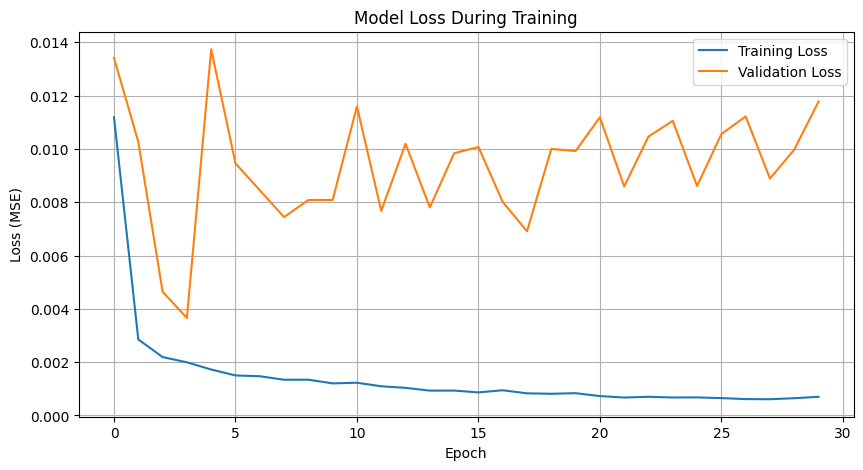

In [18]:
# Plot training vs validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()


In [19]:
predicted = model.predict(X_test)

# Reverse normalization for 'Close' price only
close_scaler = scaler.scale_[3]
close_min = scaler.min_[3]

predicted_close = predicted / close_scaler + close_min
actual_close = y_test / close_scaler + close_min


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


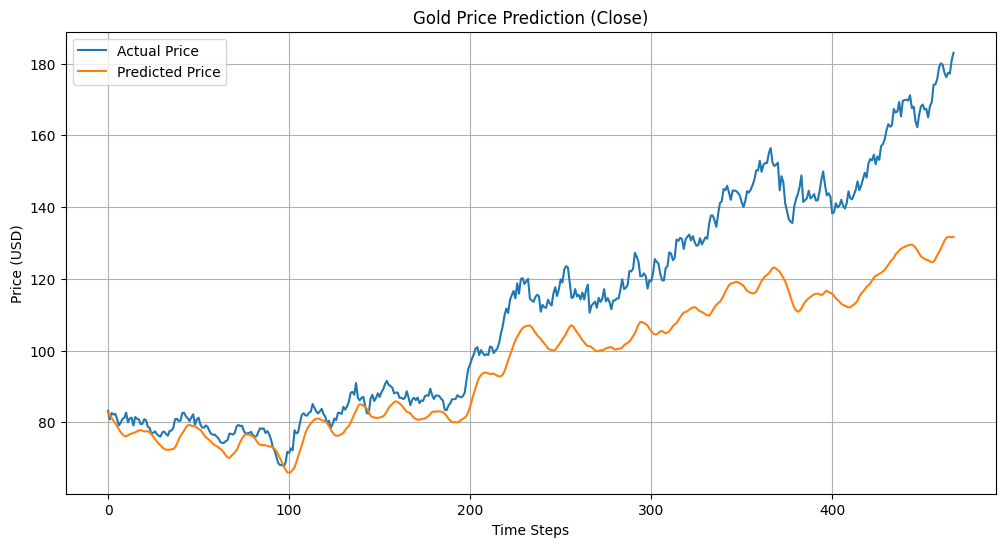

In [20]:
# Plot predicted vs actual Close prices
plt.figure(figsize=(12, 6))
plt.plot(actual_close, label='Actual Price')
plt.plot(predicted_close, label='Predicted Price')
plt.title('Gold Price Prediction (Close)')
plt.xlabel('Time Steps')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()


In [21]:
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(actual_close, predicted_close))
print("RMSE:", rmse)


RMSE: 19.92007551908695
